In [4]:
import os
import numpy as np   
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import json
from sklearn.model_selection import KFold  # Import für KFold

# Bild- und Maskenpfade laden
image_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testbilder2/'
mask_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testmasken2/'

image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

# Funktionen zum Laden und Vorverarbeiten
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path)
    img = img.resize((256, 192))
    img = np.array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

def load_and_preprocess_mask_pillow(mask_path):
    mask = Image.open(mask_path)
    mask = mask.resize((256, 192))
    mask = np.array(mask)
    mask = np.where(mask > 128, 1, 0)
    mask = np.expand_dims(mask, axis=-1)
    return mask

# Daten laden
X = np.array([load_and_preprocess_image_pillow(path) for path in image_paths])
Y = np.array([load_and_preprocess_mask_pillow(path) for path in mask_paths])

# Dice Metric
def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Benutzerdefinierte Verlustfunktion
def combined_loss(y_true, y_pred, smooth=1e-6, binary_weight=0.5, dice_weight=0.5):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)
    return binary_weight * bce + dice_weight * dice_loss

# U-Net Modell
def unet_model(input_size=(192, 256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.3)(pool1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.4)(pool2)

    conv4 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.4)(pool4)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    bottleneck = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    bottleneck = BatchNormalization()(bottleneck)

    up6 = UpSampling2D(size=(2, 2))(bottleneck)
    up6 = Conv2D(256, 2, activation='relu', padding='same')(up6)
    up6 = BatchNormalization()(up6)
    merge6 = concatenate([conv3, up6], axis=3)

    conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(128, 2, activation='relu', padding='same')(up7)
    up7 = BatchNormalization()(up7)
    merge7 = concatenate([conv2, up7], axis=3)

    conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(64, 2, activation='relu', padding='same')(up8)
    up8 = BatchNormalization()(up8)
    merge8 = concatenate([conv1, up8], axis=3)

    conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    conv8 = Conv2D(1, 1, activation='sigmoid')(conv8)

    model = Model(inputs=inputs, outputs=conv8)
    return model

# K-Fold-Validierung
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_val_loss = float('inf')
best_model = None
best_model_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_trained5.h5'

# Trainings-Konfiguration
epochs = 1000
batch_size = 8

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}/{kf.n_splits}")

    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    model = unet_model()  # Neues Modell für jeden Fold
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, binary_weight=0.5, dice_weight=0.5), metrics=[dice_metric])

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # Training
    hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[early_stopping, reduce_lr], verbose=1)

    # Speichern des besten Modells
    if hist.history['val_loss'][-1] < best_val_loss:
        best_val_loss = hist.history['val_loss'][-1]
        best_model = model
        model.save(best_model_path)

# Speichern der Trainingshistorie des letzten Modells
history_file = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/training_history.json_spheroid_segmentation_unet_trained5.h5'
with open(history_file, 'w') as f:
    json.dump(hist.history, f)

print(f"Bestes Modell wurde unter {best_model_path} gespeichert.")
print(f"Training Historie wurde unter {history_file} gespeichert.")




Fold 1/5
Epoch 1/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 823s 6s/step - dice_metric: 0.4296 - loss: 0.5662 - val_dice_metric: 0.1011 - val_loss: 0.6498 - learning_rate: 1.0000e-04
Epoch 2/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 794s 6s/step - dice_metric: 0.6371 - loss: 0.3570 - val_dice_metric: 0.0462 - val_loss: 0.7185 - learning_rate: 1.0000e-04
Epoch 3/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 838s 7s/step - dice_metric: 0.6908 - loss: 0.2743 - val_dice_metric: 0.0453 - val_loss: 0.7200 - learning_rate: 1.0000e-04
Epoch 4/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 813s 6s/step - dice_metric: 0.7636 - loss: 0.1949 - val_dice_metric: 0.0301 - val_loss: 0.7789 - learning_rate: 1.0000e-04
Epoch 5/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 798s 6s/step - dice_metric: 0.7935 - loss: 0.1740 - val_dice_metric: 0.5847 - val_loss: 0.3392 - learning_rate: 1.0000e-04
Epoch 6/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 804s 6s/step - dice_metric: 0.8351 - loss: 0.1402 - val_dice_metric: 0.7756 - val_loss: 0.1790 - learning_rate: 1.0000e-04



Fold 2/5
Epoch 1/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 768s 6s/step - dice_metric: 0.4885 - loss: 0.5010 - val_dice_metric: 0.1123 - val_loss: 0.6320 - learning_rate: 1.0000e-04
Epoch 2/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 761s 6s/step - dice_metric: 0.6506 - loss: 0.3319 - val_dice_metric: 0.0564 - val_loss: 0.6835 - learning_rate: 1.0000e-04
Epoch 3/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 761s 6s/step - dice_metric: 0.7182 - loss: 0.2510 - val_dice_metric: 0.0397 - val_loss: 0.7180 - learning_rate: 1.0000e-04
Epoch 4/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 761s 6s/step - dice_metric: 0.7528 - loss: 0.2185 - val_dice_metric: 0.2767 - val_loss: 0.5465 - learning_rate: 1.0000e-04
Epoch 5/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 762s 6s/step - dice_metric: 0.8129 - loss: 0.1578 - val_dice_metric: 0.6368 - val_loss: 0.2769 - learning_rate: 1.0000e-04
Epoch 6/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 769s 6s/step - dice_metric: 0.8133 - loss: 0.1627 - val_dice_metric: 0.8280 - val_loss: 0.1350 - learning_rate: 1.0000e-04



Fold 3/5
Epoch 1/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 829s 6s/step - dice_metric: 0.4593 - loss: 0.5256 - val_dice_metric: 0.1116 - val_loss: 0.6458 - learning_rate: 1.0000e-04
Epoch 2/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 830s 6s/step - dice_metric: 0.6530 - loss: 0.3303 - val_dice_metric: 0.0523 - val_loss: 0.7073 - learning_rate: 1.0000e-04
Epoch 3/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 846s 7s/step - dice_metric: 0.7057 - loss: 0.2608 - val_dice_metric: 0.0321 - val_loss: 0.7488 - learning_rate: 1.0000e-04
Epoch 4/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 835s 7s/step - dice_metric: 0.7853 - loss: 0.1868 - val_dice_metric: 0.0705 - val_loss: 0.7401 - learning_rate: 1.0000e-04
Epoch 5/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 811s 6s/step - dice_metric: 0.8169 - loss: 0.1535 - val_dice_metric: 0.6847 - val_loss: 0.2527 - learning_rate: 1.0000e-04
Epoch 6/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 795s 6s/step - dice_metric: 0.8454 - loss: 0.1311 - val_dice_metric: 0.7157 - val_loss: 0.2522 - learning_rate: 1.0000e-04


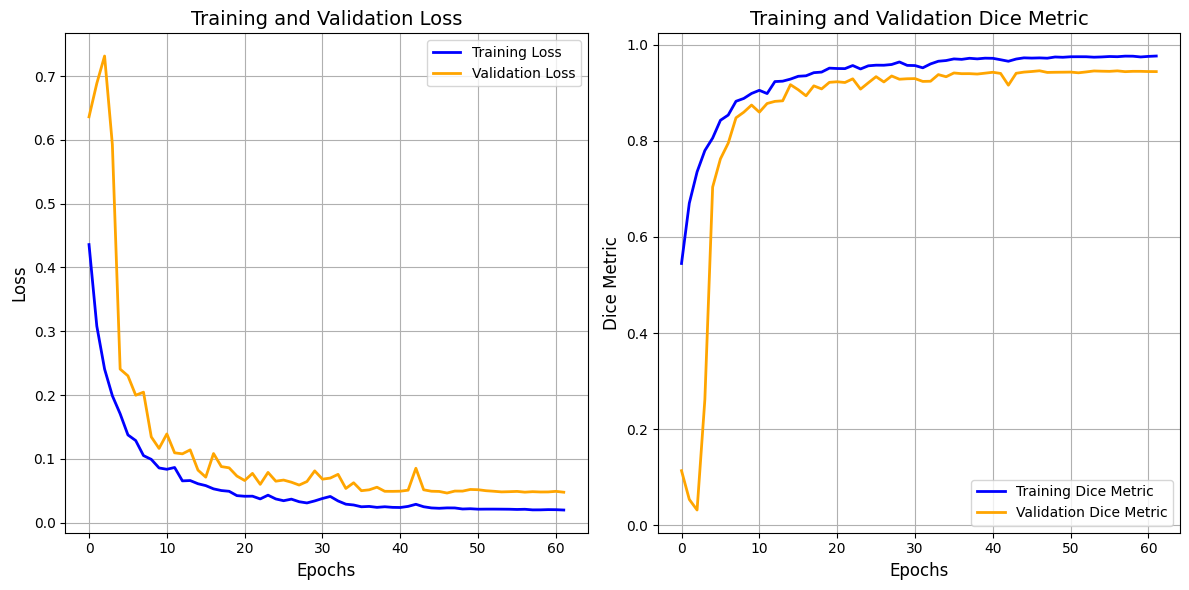

In [7]:
import json
import matplotlib.pyplot as plt

# Lade den Trainingsverlauf aus der JSON-Datei
history_file = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/training_history.json_spheroid_segmentation_unet_trained5.h5'
# Öffnen und Laden der JSON-Datei
with open(history_file, 'r') as Trainingsverlauf:
    history = json.load(Trainingsverlauf)

# Plotten
plt.figure(figsize=(12, 6))  # Breite und Höhe des gesamten Plots

# Verlust (Loss)
plt.subplot(1, 2, 1)  # 1 Zeile, 2 Spalten, 1. Plot
plt.plot(history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Dice Metric
plt.subplot(1, 2, 2)  # 1 Zeile, 2 Spalten, 2. Plot
plt.plot(history['dice_metric'], label='Training Dice Metric', color='blue', linewidth=2)
plt.plot(history['val_dice_metric'], label='Validation Dice Metric', color='orange', linewidth=2)
plt.title('Training and Validation Dice Metric', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Dice Metric', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Abstände zwischen den Subplots anpassen
plt.tight_layout()

# Plot anzeigen und speichern
plt.savefig('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/training_history_spheroid_segmentation_unet_trained5.1.png')
plt.show()
